## Tomograf
1. Dołączenie bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
import matplotlib.animation as animation
import scipy.signal as sig

from bresenham import get_line
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

2.
Generowanie sinogramu na podstawie obrazka 


In [2]:
# alpha - kąt przesunięcia detektorów  
# detectors - liczba detektorów
# distance - odległość między sąsiednimi detektorami w stopniach

a = widgets.FloatSlider(min = 0.1, max = 2, step = 0.1)
b = widgets.IntSlider(min = 5, max = 400, step = 5)
c = widgets.IntSlider(min = 5, max = 360, step = 5)
display(a)
display(b)
display(c)



FloatSlider(value=0.1, max=2.0, min=0.1)

IntSlider(value=5, max=400, min=5, step=5)

IntSlider(value=5, max=360, min=5, step=5)

In [3]:
alpha = a.value
detectors = b.value
width = c.value
print("alpha: ",  alpha)
print("detectors: ",  detectors)
print("width: ",  width)

alpha:  1.0
detectors:  205
width:  110


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


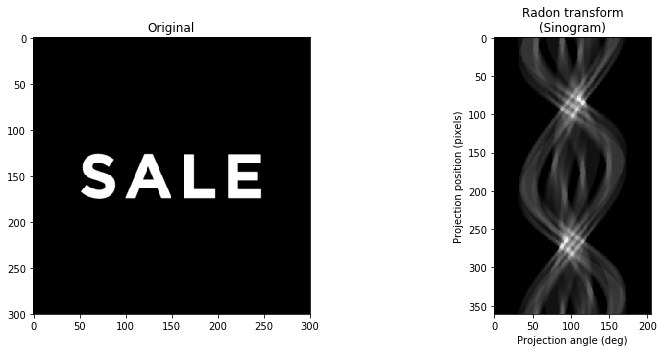

In [4]:

class Pixel:
    def __init__(self):
        self.maximum = int(0)
        self.normalized = np.float(0)
        self.raw = np.float(0)


def image2sinogram(image, alpha, detectors, width):

    
    

    sinogram = []
    lines = []

    image_size = len(image)
    i = 0

    while i <= 360:
            #print(i)
            sinogram.append([])
            lines.append([])
            i += alpha
            for detector in range(0, detectors):
                x0 = image_size * np.cos(i * np.pi / 180)
                y0 = image_size * np.sin(i * np.pi / 180)

                x1 = image_size * np.cos((i + 180 - (width / 2) + detector * (width / (detectors - 1))) * np.pi / 180)
                y1 = image_size * np.sin((i + 180 - (width / 2) + detector * (width / (detectors - 1))) * np.pi / 180)



                x0 = int(x0) + np.float(image_size/2)
                x1 = int(x1) + np.float(image_size/2)
                y0 = int(y0) + np.float(image_size/2)
                y1 = int(y1) + np.float(image_size/2)

                line = get_line(x0, y0, x1, y1)
            


                pixel = get_pixel_value(image, line)

                sinogram[-1].append(pixel.normalized)
                lines[-1].append([x0, y0, x1, y1])
                
           
                


    return sinogram, lines


def get_pixel_value(picture, line):
    pixel = Pixel()
    for pos in line:
        if pos[0] >= 0 and pos[1] >= 0 and pos[0] < len(picture) and pos[1] < len(picture):
            pixel.raw += float(picture[int(pos[0]),int(pos[1])])
            pixel.maximum += 1
    if(pixel.maximum == 0):
        pixel.normalized = 1
        return pixel
    # assert pixel.maximum != 0
    else:
        pixel.normalized = pixel.raw / pixel.maximum

        return pixel






image= misc.imread(os.path.join('image3.bmp'), flatten= 1).astype('float64')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

sinogram, lines = image2sinogram(image, alpha, detectors, width)

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap='gray')




fig.tight_layout()
plt.show()




In [5]:
def f(a):
   
    
    return plt.imshow(sinogram[:a], cmap='gray')


w = interactive(f, a = widgets.IntSlider(min = 2, max = 360, step = 2))
display(w)

interactive(children=(IntSlider(value=2, description='a', max=360, min=2, step=2), Output()), _dom_classes=('w…

<b>Rekonstrukcja obrazka z sinogramu</b>

Krok po kroku - można rekonstruować obrazek po liniach sinogramu

In [6]:
d = widgets.IntSlider(min = 1, max = np.shape(sinogram)[0], step = 1)
display(d)

IntSlider(value=1, max=361, min=1)

In [14]:
reconstruction_steps=d.value
print("reconstruction_steps: ", d.value)

reconstruction_steps:  59


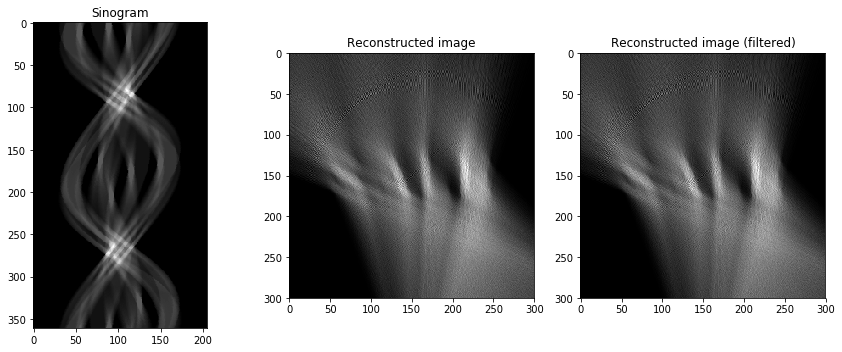

In [15]:
def sinogram_to_image(picture, sinogram, lines):

    width = np.shape(picture)[0]
    height = np.shape(picture)[1]
    f_sinogram=filter(sinogram)
    sinogram_shape = np.shape(sinogram)
    number_of_projections=reconstruction_steps
    number_of_detectors = sinogram_shape[1]

    new_image = np.zeros(shape=np.shape(picture))
    filtered_image=new_image

    for projection in range(0, number_of_projections):
        for detector in range(0, number_of_detectors):
            x0, y0, x1, y1 = lines[projection][detector]
            line = get_line(x0, y0, x1, y1)
            value = sinogram[projection][detector]
            f_value = f_sinogram[projection][detector]
            for i in range(0, len(line)):
                    x, y = line[i]
                    if 0 <= x < width and 0 <= y < height:
                        new_image[int(x)][int(y)] += value
                        filtered_image[int(x)][int(y)] += f_value
    return new_image, filtered_image


def filter(sinogram):
    sinogram_shape = np.shape(sinogram)
    number_of_projections = sinogram_shape[0]

    filtered = []
    mask = [-2,5,2]

    for projection in range(0, number_of_projections):
        filtered.append(sig.convolve(sinogram[projection], mask, mode='same', method='direct'))

    return filtered





reverse, filtered_reverse = sinogram_to_image(image, sinogram, lines)
  
fig1, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(12, 5))

ax3.set_title("Sinogram")
ax3.imshow(sinogram, cmap='gray')

ax4.set_title("Reconstructed image")
ax4.imshow(reverse, cmap='gray')
ax5.set_title("Reconstructed image (filtered)")
ax5.imshow(filtered_reverse, cmap='gray')


fig1.tight_layout()
plt.show()